# 3 Classification

In [2]:
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [3]:
train_data = datasets.FashionMNIST(root='data', 
                                   train=True, 
                                   download=True, 
                                   transform=ToTensor())

test_data = datasets.FashionMNIST(root='data', 
                                  train=False,
                                  transform=ToTensor(),
                                  download=True)

train, valid = random_split(train_data, [50000, 10000])

train_loader = DataLoader(dataset=train, 
                          batch_size=100, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid, 
                          batch_size=100, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=100, 
                         shuffle=False)


In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)        
        x = self.l4(x)
        return x
        

In [5]:
def fit_model(model, opt, criterion, x, y):
    opt.zero_grad()
    preds = model(x)
    train_loss = criterion(preds, y)
    train_loss.backward()
    opt.step()

In [6]:
def validate_model(model, criterion, valid_data):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in valid_data:
            preds = model(x)
            valid_loss = criterion(preds, y)
            _, predicted = torch.max(preds.data, 1)
            n_samples += y.size(0)
            n_correct += (predicted == y).sum().item()
        accuracy = 100.0 * n_correct / n_samples
    return valid_loss.item(), accuracy

In [6]:
def load_model(path):
    model = torch.load(path)
    return model

In [7]:
best_over_all_hyperparameters = None
best_over_all_loss = np.inf

In [8]:
def fit_evaluate_and_save(train_data, valid_data, optimizer='Adam', learning_rate=None, num_epochs=10, criterion=cross_entropy, scale_data=False):
    model = NeuralNetwork(28*28, 10)
    min_valid_loss = np.inf
    accuracy_for_best_model = 0
    global best_over_all_loss
    global best_over_all_hyperparameters
    
    if scale_data:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
    
    if optimizer == 'Adam':
        if learning_rate:
            opt = Adam(model.parameters(), lr=learning_rate)
        else: 
            opt = Adam(model.parameters())
            learning_rate = 0.001 # default learning rate for Adam
    elif optimizer == 'SGD':
        opt = SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for x, y in train_data:
            fit_model(model, opt, criterion, x, y)
        
        valid_loss, accuracy = validate_model(model, criterion, valid_data)
        
        if (epoch+1) % 2 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Validation loss: {valid_loss}, Accuracy: {accuracy}')
        
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            accuracy_for_best_model = accuracy
            torch.save(model, 'best_model.pt')
        
        if best_over_all_loss > valid_loss:
            best_over_all_loss = valid_loss
            best_over_all_hyperparameters = {'Optimizer': optimizer, 'Learning rate': learning_rate}
        
    print(f'{"-"*10}\nBEST RESULT Loss: {min_valid_loss}, Accuracy: {accuracy_for_best_model}')

## Optimizer: Adam

In [9]:
print(f'Batch size: 32\nOptimizer: Adam\nLearning rate: default (0.001)\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader)

Batch size: 32
Optimizer: Adam
Learning rate: default (0.001)
----------
Epoch: 2/10, Validation loss: 0.31121718883514404, Accuracy: 86.72
Epoch: 4/10, Validation loss: 0.3210783898830414, Accuracy: 87.92
Epoch: 6/10, Validation loss: 0.23818263411521912, Accuracy: 88.6
Epoch: 8/10, Validation loss: 0.2879265546798706, Accuracy: 88.26
Epoch: 10/10, Validation loss: 0.22046878933906555, Accuracy: 89.23
----------
BEST RESULT Loss: 0.22046878933906555, Accuracy: 89.23


#### With learning rate

In [10]:
print(f'Batch size: 32\nOptimizer: Adam\nLearning rate: 0.01\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, learning_rate=0.01)

Batch size: 32
Optimizer: Adam
Learning rate: 0.01
----------
Epoch: 2/10, Validation loss: 0.5346977710723877, Accuracy: 84.3
Epoch: 4/10, Validation loss: 0.3484540581703186, Accuracy: 85.42
Epoch: 6/10, Validation loss: 0.4495679438114166, Accuracy: 85.86
Epoch: 8/10, Validation loss: 0.33930516242980957, Accuracy: 86.44
Epoch: 10/10, Validation loss: 0.4314340353012085, Accuracy: 86.93
----------
BEST RESULT Loss: 0.2498931884765625, Accuracy: 85.93


In [11]:
print(f'Batch size: 32\nOptimizer: Adam\nLearning rate: 0.0001\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, learning_rate=0.0001)

Batch size: 32
Optimizer: Adam
Learning rate: 0.0001
----------
Epoch: 2/10, Validation loss: 0.5266912579536438, Accuracy: 83.69
Epoch: 4/10, Validation loss: 0.6224396824836731, Accuracy: 85.89
Epoch: 6/10, Validation loss: 0.36769646406173706, Accuracy: 86.29
Epoch: 8/10, Validation loss: 0.35642287135124207, Accuracy: 87.04
Epoch: 10/10, Validation loss: 0.29495781660079956, Accuracy: 87.27
----------
BEST RESULT Loss: 0.29495781660079956, Accuracy: 87.27


## Optimizer: SGD

#### With learning rate

In [12]:
print(f'Batch size: 32\nOptimizer: SGD\nLearning rate: 0.1\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, optimizer='SGD', learning_rate=0.1)

Batch size: 32
Optimizer: SGD
Learning rate: 0.1
----------
Epoch: 2/10, Validation loss: 0.4222935438156128, Accuracy: 84.05
Epoch: 4/10, Validation loss: 0.2771618366241455, Accuracy: 85.0
Epoch: 6/10, Validation loss: 0.5280365943908691, Accuracy: 87.31
Epoch: 8/10, Validation loss: 0.26415643095970154, Accuracy: 87.19
Epoch: 10/10, Validation loss: 0.5067051649093628, Accuracy: 86.85
----------
BEST RESULT Loss: 0.26415643095970154, Accuracy: 87.19


In [13]:
print(f'Batch size: 32\nOptimizer: SGD\nLearning rate: 0.2\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, optimizer='SGD', learning_rate=0.2)

Batch size: 32
Optimizer: SGD
Learning rate: 0.2
----------
Epoch: 2/10, Validation loss: 0.490193247795105, Accuracy: 82.19
Epoch: 4/10, Validation loss: 0.32334476709365845, Accuracy: 86.04
Epoch: 6/10, Validation loss: 0.36150795221328735, Accuracy: 87.73
Epoch: 8/10, Validation loss: 0.3986224830150604, Accuracy: 87.32
Epoch: 10/10, Validation loss: 0.25883522629737854, Accuracy: 88.31
----------
BEST RESULT Loss: 0.25883522629737854, Accuracy: 88.31


In [14]:
print(f'Batch size: 32\nOptimizer: SGD\nLearning rate: 0.3\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, optimizer='SGD', learning_rate=0.3)

Batch size: 32
Optimizer: SGD
Learning rate: 0.3
----------
Epoch: 2/10, Validation loss: 0.3973372280597687, Accuracy: 85.31
Epoch: 4/10, Validation loss: 0.3543364405632019, Accuracy: 85.21
Epoch: 6/10, Validation loss: 0.3452518880367279, Accuracy: 86.53
Epoch: 8/10, Validation loss: 0.40305545926094055, Accuracy: 85.07
Epoch: 10/10, Validation loss: 0.39225396513938904, Accuracy: 88.24
----------
BEST RESULT Loss: 0.2488970160484314, Accuracy: 88.65


In [15]:
print(f'Batch size: 32\nOptimizer: SGD\nLearning rate: 0.4\n{"-"*10}')
fit_evaluate_and_save(train_loader, valid_loader, optimizer='SGD', learning_rate=0.4)

Batch size: 32
Optimizer: SGD
Learning rate: 0.4
----------
Epoch: 2/10, Validation loss: 0.4076199233531952, Accuracy: 84.34
Epoch: 4/10, Validation loss: 0.4473590552806854, Accuracy: 87.0
Epoch: 6/10, Validation loss: 0.3730437159538269, Accuracy: 87.96
Epoch: 8/10, Validation loss: 0.5339323878288269, Accuracy: 84.44
Epoch: 10/10, Validation loss: 0.43703749775886536, Accuracy: 89.08
----------
BEST RESULT Loss: 0.3243286907672882, Accuracy: 87.06


## Best hypermarameters found

In [16]:
print(f'Optmizer: {best_over_all_hyperparameters["Optimizer"]}\nLearning rate: {best_over_all_hyperparameters["Learning rate"]}')

Optmizer: Adam
Learning rate: 0.001


## Confusion matrix

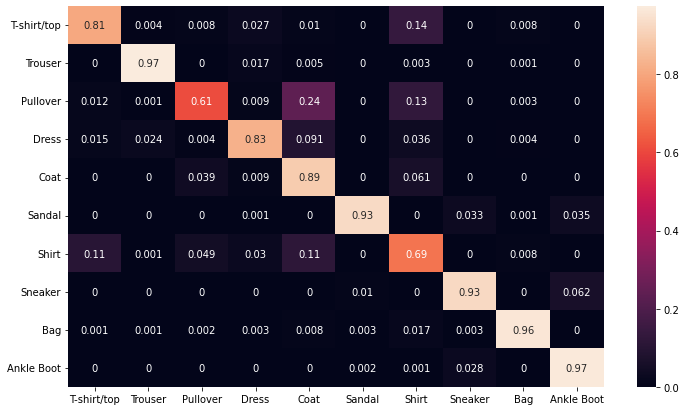

In [17]:
model = load_model('best_model.pt')

y_pred = []
y_true = []

for x, y in test_loader:
    preds = model(x)
    preds = (torch.max(preds, 1)[1]).data.cpu().numpy()
    y_pred.extend(preds)
    
    y = y.data.cpu().numpy()
    y_true.extend(y)

    
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
    
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, 
                     index = [c for c in classes], 
                     columns = [c for c in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
    

## Compare time for different batch sizes 

In [21]:
def create_and_fit_model(train_data, num_epochs=3, criterion=cross_entropy):
    model = NeuralNetwork(28*28, 10)
    opt = Adam(model.parameters())
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_data):
            opt.zero_grad()
            preds = model(x)
            train_loss = criterion(preds, y)
            train_loss.backward()
            opt.step()

In [26]:
batch_sizes = [2, 4, 8, 16, 32]
times = []
for batch_size in batch_sizes:
    train_loader = DataLoader(dataset=train, 
                              batch_size=batch_size, 
                              shuffle=True)
    start = datetime.now()
    create_and_fit_model(train_loader)
    stop = datetime.now()
    time = stop - start
    times.append(time.seconds)
    print(f'Batch size: {batch_size}, time: {time}')

Batch size: 2, time: 0:08:07.393935
Batch size: 4, time: 0:03:15.860310
Batch size: 8, time: 0:01:53.548780
Batch size: 16, time: 0:01:10.099561
Batch size: 32, time: 0:00:48.904260


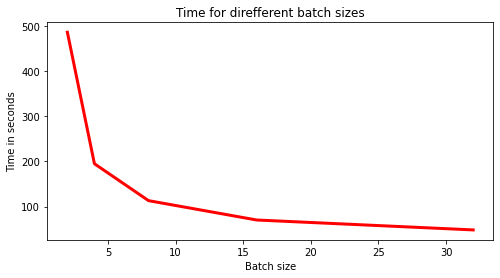

In [27]:
fig, ax = plt.subplots(figsize = (8,4))
ax.set_xlabel('Batch size')
ax.set_ylabel('Time in seconds')
ax.plot(batch_sizes, times, linewidth=3.0, c='Red')
plt.title('Time for direfferent batch sizes')
plt.show()